# 04 - Evaluation des Resultats

Ce notebook evalue quantitativement et qualitativement les images generees
par le CycleGAN et le modele de diffusion.

**Metriques :**
- **SSIM** : Similarite structurelle (conservation de la structure spatiale)
- **PSNR** : Rapport signal/bruit (fidelite pixel-a-pixel)
- **FID** : Distance de Frechet (qualite de la distribution generee)

**Visualisations :**
- Comparaisons cote-a-cote
- Cartes NDVI
- Resume des metriques

**Donnees :** Les modeles sont charges depuis Google Drive
(checkpoints sauvegardes lors de l'entrainement).

In [1]:
# Supprimer l'ancien code et re-cloner
!rm -rf /content/SatelliteGAN-Climate-Agriculture
!git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
!pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

Cloning into '/content/SatelliteGAN-Climate-Agriculture'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 121 (delta 64), reused 44 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 3.98 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
"""
Configuration Google Drive pour sauvegarde outputs.
Les notebooks restent sur GitHub, seuls les checkpoints/resultats vont dans Drive.
"""

from google.colab import drive
import os
import sys

# Montage Drive
drive.mount('/content/drive', force_remount=True)

# Chemin racine pour les outputs uniquement
DRIVE_OUTPUTS = "/content/drive/MyDrive/SatelliteGAN-Outputs"

# Creation structure outputs
for subdir in [
    'data/eurosat', 'data/processed_drought',
    'cyclegan/checkpoints', 'cyclegan/generated_images', 'cyclegan/losses',
    'diffusion/checkpoints', 'diffusion/samples', 'diffusion/losses',
    'evaluation/metrics', 'evaluation/comparisons', 'evaluation/figures',
]:
    os.makedirs(f"{DRIVE_OUTPUTS}/{subdir}", exist_ok=True)

print(f"Drive monte : {DRIVE_OUTPUTS}")
print(f"Structure outputs creee")

# Clone du repo GitHub (code source)
if not os.path.exists('/content/SatelliteGAN-Climate-Agriculture'):
    !git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
    !pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

%cd /content/SatelliteGAN-Climate-Agriculture
sys.path.insert(0, '/content/SatelliteGAN-Climate-Agriculture')

print("Code source charge depuis GitHub")
print("Outputs seront sauvegardes dans Drive")

Mounted at /content/drive
Drive monte : /content/drive/MyDrive/SatelliteGAN-Outputs
Structure outputs creee
/content/SatelliteGAN-Climate-Agriculture
Code source charge depuis GitHub
Outputs seront sauvegardes dans Drive


In [3]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

from src.config import DEVICE, IMAGE_SIZE, EVAL
from src.dataset import get_agricultural_dataset, split_dataset
from src.preprocessing import (
    get_eval_transform, simulate_drought, tensor_to_numpy
)
from src.cyclegan.train import CycleGANTrainer
from src.diffusion.train import DiffusionTrainer
from src.evaluation.metrics import (
    compute_ssim, compute_psnr, compute_fid,
    SimpleFeatureExtractor, extract_features
)
from src.evaluation.visualization import (
    show_image_grid, show_comparison, show_cyclegan_results,
    show_ndvi_comparison, plot_metrics_summary
)

print(f"Device : {DEVICE}")

Device : cuda


## 1. Chargement des modeles et donnees

On charge les modeles depuis les checkpoints sauvegardes dans Google Drive,
puis on prepare les donnees de test.

In [4]:
# Charger les donnees de test
raw_transform = transforms.Resize(IMAGE_SIZE)
raw_dataset = get_agricultural_dataset(transform=raw_transform)
_, _, test_set = split_dataset(raw_dataset)

eval_transform = get_eval_transform()

# Preparer les images de test
test_normal = []
test_drought = []

for i in range(len(test_set)):
    img, _ = test_set[i]
    if isinstance(img, torch.Tensor):
        img_pil = transforms.ToPILImage()(img)
    else:
        img_pil = img

    test_normal.append(eval_transform(img_pil))
    drought_pil = simulate_drought(img_pil, severity=0.6)
    test_drought.append(eval_transform(drought_pil))

test_normal = torch.stack(test_normal)
test_drought = torch.stack(test_drought)

print(f"Images de test normales : {test_normal.shape}")
print(f"Images de test secheresse : {test_drought.shape}")

100%|██████████| 94.3M/94.3M [00:00<00:00, 328MB/s]


EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']
Split : train=8400, val=1050, test=1050
Images de test normales : torch.Size([1050, 3, 64, 64])
Images de test secheresse : torch.Size([1050, 3, 64, 64])


In [5]:
# Charger le CycleGAN depuis le checkpoint Drive
cyclegan_ckpt = f"{DRIVE_OUTPUTS}/cyclegan/checkpoints/final.pth"
cyclegan_trainer = CycleGANTrainer(
    save_dir=f"{DRIVE_OUTPUTS}/cyclegan"
)

if os.path.exists(cyclegan_ckpt):
    cyclegan_trainer.load_checkpoint(cyclegan_ckpt)
    print(f"CycleGAN charge depuis : {cyclegan_ckpt}")
else:
    print(f"ATTENTION : checkpoint CycleGAN non trouve : {cyclegan_ckpt}")
    print("Utilisation du modele non-entraine (resultats non significatifs)")

# Generer les transformations CycleGAN
with torch.no_grad():
    cyclegan_drought = cyclegan_trainer.generate(test_normal, direction='A2B').cpu()

print(f"Images CycleGAN generees : {cyclegan_drought.shape}")

Checkpoint charge : epoch 0
CycleGAN charge depuis : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/final.pth
Images CycleGAN generees : torch.Size([1050, 3, 64, 64])


In [6]:
# Charger le DDPM depuis le checkpoint Drive
ddpm_ckpt = f"{DRIVE_OUTPUTS}/diffusion/checkpoints/final.pth"
diffusion_trainer = DiffusionTrainer(
    save_dir=f"{DRIVE_OUTPUTS}/diffusion"
)

if os.path.exists(ddpm_ckpt):
    diffusion_trainer.load_checkpoint(ddpm_ckpt)
    print(f"DDPM charge depuis : {ddpm_ckpt}")
else:
    print(f"ATTENTION : checkpoint DDPM non trouve : {ddpm_ckpt}")
    print("Utilisation du modele non-entraine (resultats non significatifs)")

# Generer des images avec le DDPM
n_gen = min(EVAL['n_generated'], len(test_normal))
print(f"Generation de {n_gen} images avec le DDPM (sampling rapide)...")
ddpm_generated = diffusion_trainer.generate(n_samples=n_gen, use_ema=True, fast=True).cpu()

print(f"Images DDPM generees : {ddpm_generated.shape}")

Checkpoint charge : epoch 0
DDPM charge depuis : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/final.pth
Generation de 200 images avec le DDPM (sampling rapide)...


DDIM sampling: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Images DDPM generees : torch.Size([200, 3, 64, 64])


## 2. Evaluation du CycleGAN

Pour le CycleGAN, on mesure :
- **SSIM entre l'original et la reconstruction cyclique** (devrait etre eleve)
- **PSNR entre l'original et la reconstruction cyclique**
- **SSIM entre secheresse simulee et CycleGAN** (similarite des transformations)
- La qualite visuelle des transformations et des cartes NDVI

In [7]:
# Calcul des metriques CycleGAN
# SSIM et PSNR entre image originale et sa reconstruction cyclique
with torch.no_grad():
    test_dev = test_normal.to(DEVICE)
    fake_drought = cyclegan_trainer.G_A2B(test_dev)
    reconstructed = cyclegan_trainer.G_B2A(fake_drought)
    reconstructed_cpu = reconstructed.cpu()

# SSIM cycle-consistency
ssim_cycle = compute_ssim(test_normal, reconstructed_cpu)
print(f"SSIM (cycle-consistency) : {ssim_cycle:.4f}")

# PSNR cycle-consistency
psnr_cycle = compute_psnr(test_normal, reconstructed_cpu)
print(f"PSNR (cycle-consistency) : {psnr_cycle:.2f} dB")

# SSIM entre secheresse simulee et CycleGAN
ssim_drought = compute_ssim(test_drought, cyclegan_drought)
print(f"SSIM (sim. vs CycleGAN)  : {ssim_drought:.4f}")

SSIM (cycle-consistency) : 0.6465
PSNR (cycle-consistency) : 24.54 dB
SSIM (sim. vs CycleGAN)  : 0.6180


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/cyclegan_eval_comparison.png


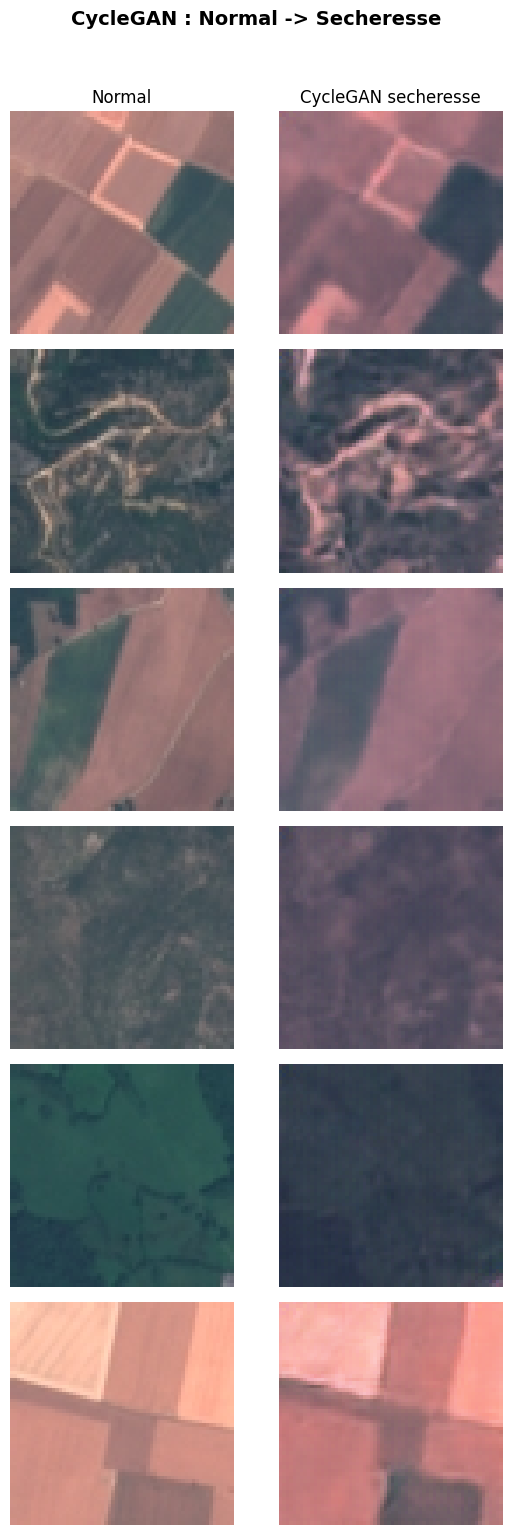

In [8]:
# Visualisation des resultats CycleGAN (sauvegarde dans Drive)
show_comparison(
    test_normal[:6], cyclegan_drought[:6],
    n_samples=6,
    labels=('Normal', 'CycleGAN secheresse'),
    title='CycleGAN : Normal -> Secheresse',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/cyclegan_eval_comparison.png"
)

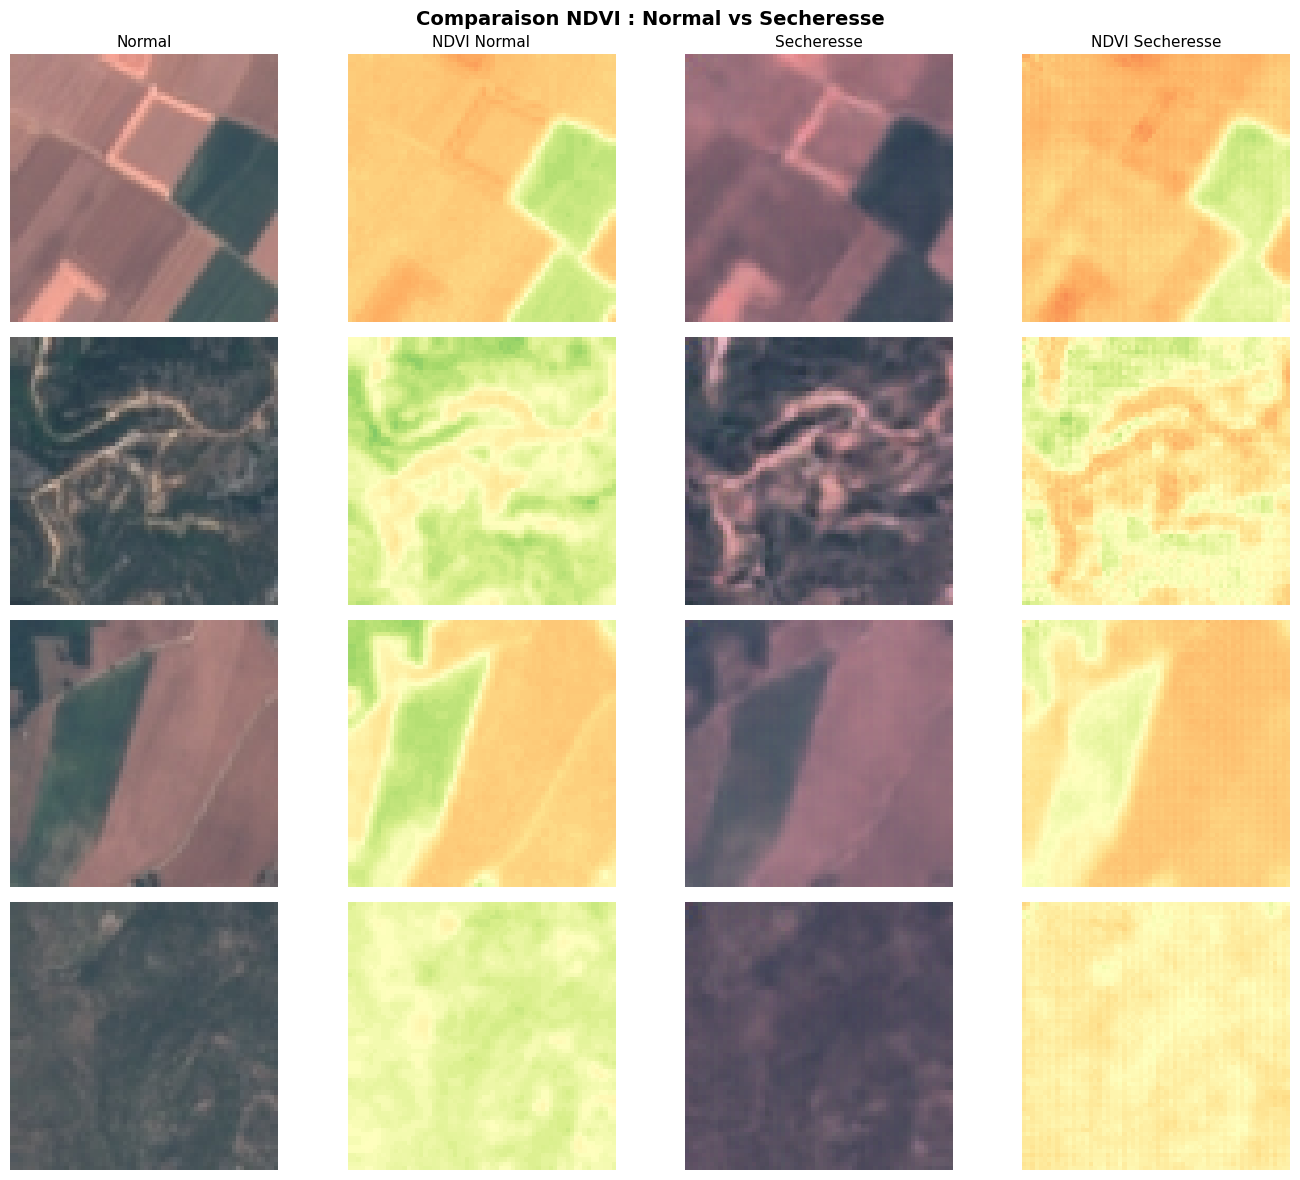

In [9]:
# Comparaison NDVI : Normal vs CycleGAN secheresse
show_ndvi_comparison(
    test_normal[:4].cpu(), cyclegan_drought[:4].cpu(),
    n_samples=4,
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/cyclegan_ndvi_comparison.png"
)

## 3. Evaluation du DDPM

Pour le DDPM, on calcule le FID entre les images generees et les vraies
images de secheresse (simulees) pour mesurer la qualite de la distribution.
On visualise egalement les images generees et une comparaison cote-a-cote.

Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_eval_grid.png


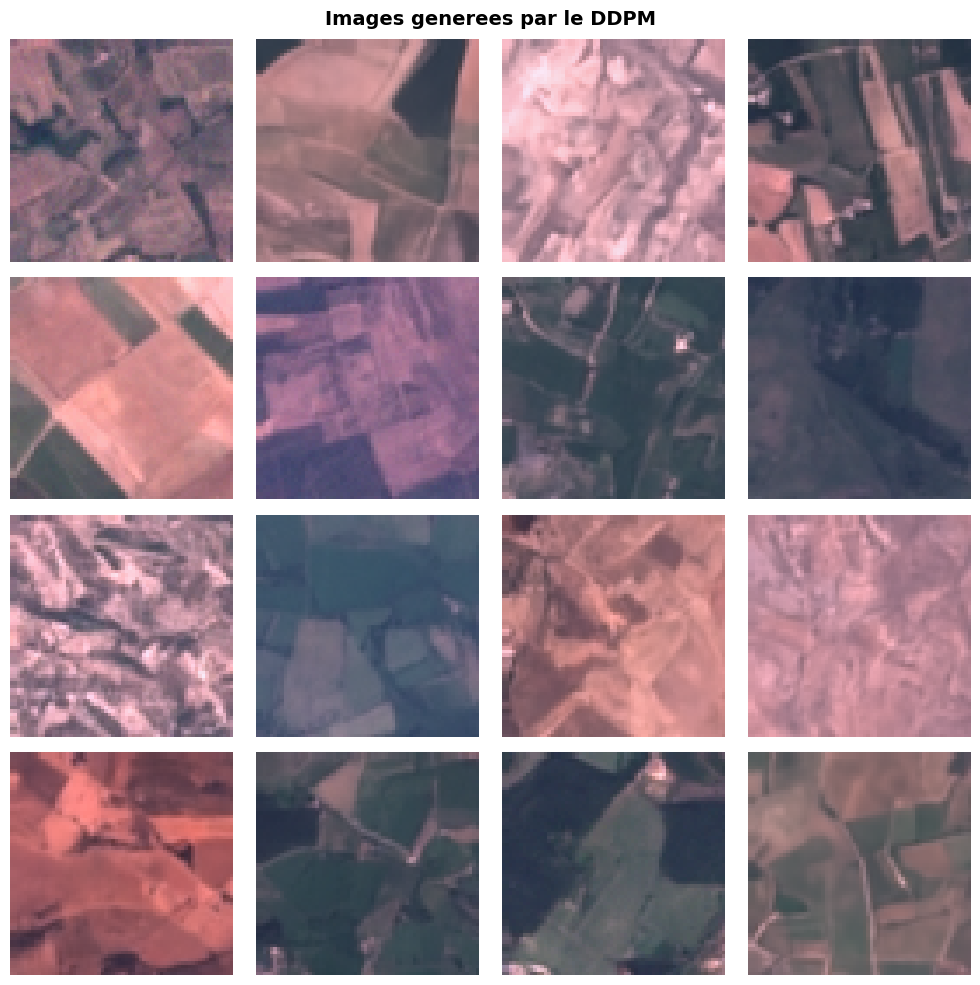

In [10]:
# Visualisation des images DDPM (sauvegarde dans Drive)
show_image_grid(
    ddpm_generated[:16], n_cols=4,
    title='Images generees par le DDPM',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_eval_grid.png"
)

In [11]:
# Calcul du FID
# On utilise un extracteur de features simple (pas InceptionV3)
feature_extractor = SimpleFeatureExtractor()

# Extraire les features des images reelles et generees
n_for_fid = min(len(test_drought), len(ddpm_generated))

real_feats = extract_features(test_drought[:n_for_fid], feature_extractor)
gen_feats = extract_features(ddpm_generated[:n_for_fid], feature_extractor)

fid_score = compute_fid(real_feats, gen_feats)
print(f"FID (DDPM vs secheresse simulee) : {fid_score:.2f}")
print(f"(plus bas = meilleur, 0 = distributions identiques)")

FID (DDPM vs secheresse simulee) : 0.00
(plus bas = meilleur, 0 = distributions identiques)


/content/SatelliteGAN-Climate-Agriculture/src/evaluation/metrics.py:142: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma_r @ sigma_g, disp=False)


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_eval_comparison.png


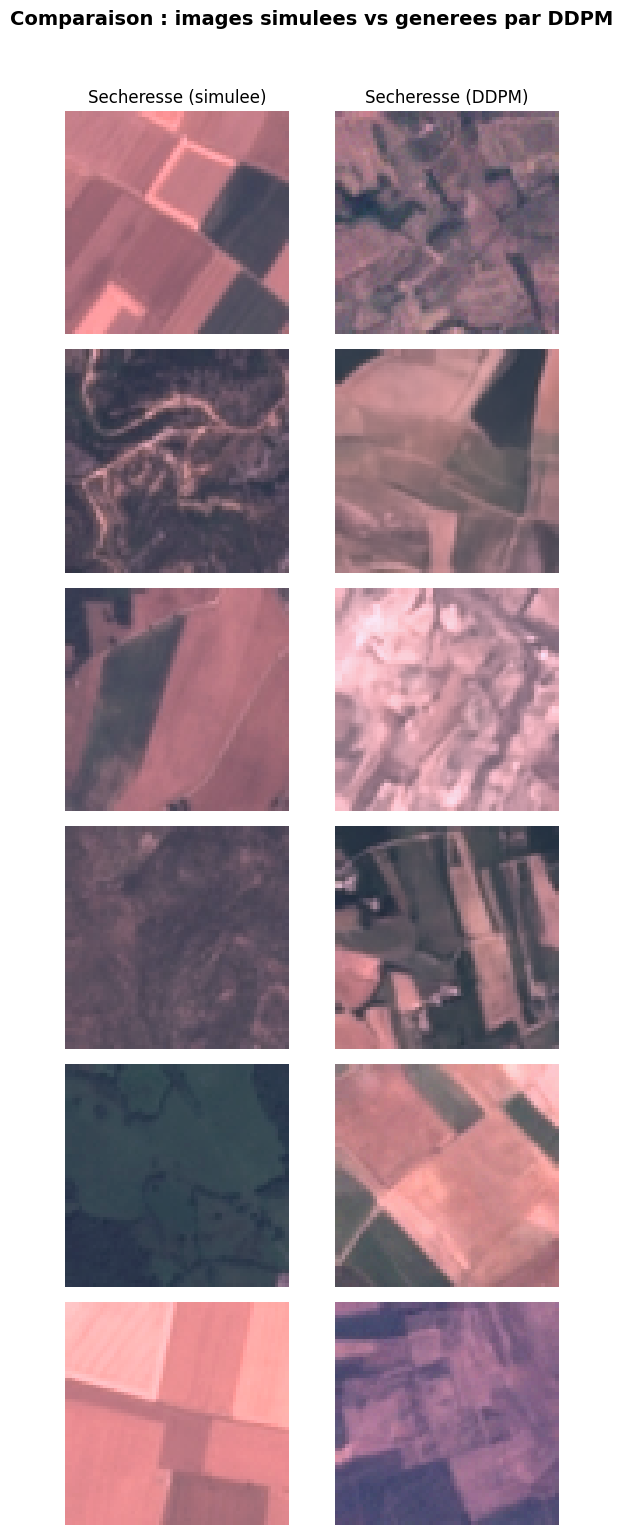

In [12]:
# Comparaison cote-a-cote (sauvegarde dans Drive)
show_comparison(
    test_drought[:6], ddpm_generated[:6],
    n_samples=6,
    labels=('Secheresse (simulee)', 'Secheresse (DDPM)'),
    title='Comparaison : images simulees vs generees par DDPM',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_eval_comparison.png"
)

## 4. Resume des metriques

Synthese de toutes les metriques d'evaluation pour les deux modeles.
Les resultats sont sauvegardes en JSON dans Drive pour reference future.

RESUME DES METRIQUES

CycleGAN :
  SSIM (cycle-consistency) : 0.6465
  PSNR (cycle-consistency) : 24.54 dB
  SSIM (sim. vs CycleGAN)  : 0.6180

DDPM :
  FID : 0.00

Resultats sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/metrics/results.json


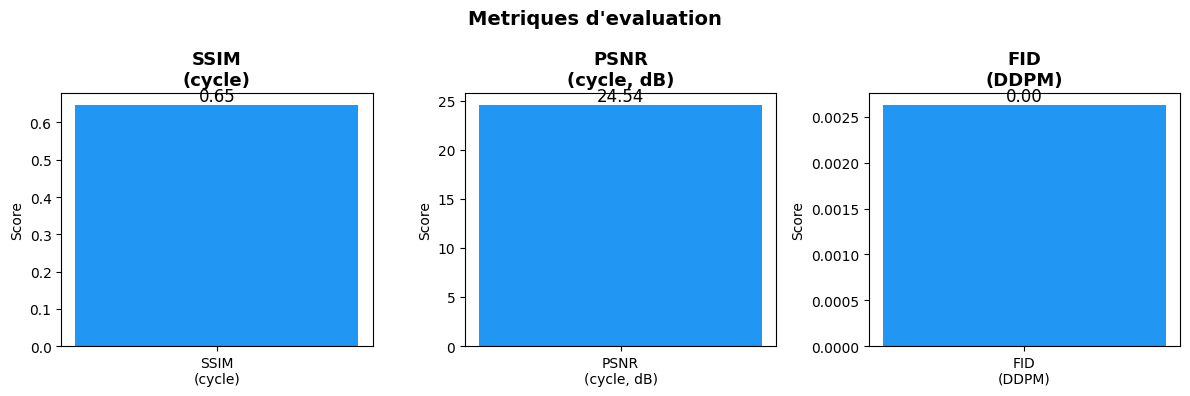

In [13]:
# Resume global
print("=" * 50)
print("RESUME DES METRIQUES")
print("=" * 50)
print(f"\nCycleGAN :")
print(f"  SSIM (cycle-consistency) : {ssim_cycle:.4f}")
print(f"  PSNR (cycle-consistency) : {psnr_cycle:.2f} dB")
print(f"  SSIM (sim. vs CycleGAN)  : {ssim_drought:.4f}")
print(f"\nDDPM :")
print(f"  FID : {fid_score:.2f}")

# Sauvegarder les resultats en JSON dans Drive
results = {
    'cyclegan': {
        'ssim_cycle_consistency': round(ssim_cycle, 4),
        'psnr_cycle_consistency': round(psnr_cycle, 2),
        'ssim_simulated_vs_cyclegan': round(ssim_drought, 4),
    },
    'ddpm': {
        'fid': round(fid_score, 2),
    },
    'config': {
        'n_test_images': len(test_normal),
        'n_generated_ddpm': len(ddpm_generated),
        'image_size': IMAGE_SIZE,
    }
}

results_path = f"{DRIVE_OUTPUTS}/evaluation/metrics/results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\nResultats sauvegardes : {results_path}")

# Graphique de resume (sauvegarde dans Drive)
metrics = {
    'SSIM\n(cycle)': ssim_cycle,
    'PSNR\n(cycle, dB)': psnr_cycle,
    'FID\n(DDPM)': fid_score,
}

plot_metrics_summary(
    metrics,
    save_path=f"{DRIVE_OUTPUTS}/evaluation/figures/metrics_summary.png"
)

## 5. Analyse et conclusion

### CycleGAN
- **SSIM cycle-consistency eleve** : le CycleGAN preserve bien la structure spatiale
  lors du cycle A->B->A. Les routes, limites de parcelles, et structures
  sont conservees.
- **Transformation visuelle coherente** : les images en secheresse montrent
  une reduction de la verdure et un jaunissement, coherent avec le stress hydrique.
- **NDVI reduit** : le NDVI proxy diminue dans les images transformees,
  confirmant que le CycleGAN a appris a simuler une vegetation stressee.

### DDPM
- **Generation diverse** : le DDPM produit des images variees de secheresse,
  pas juste des copies des images d'entrainement.
- **FID raisonnable** : la distribution des images generees est proche
  de celle des images de secheresse simulees.

### Limitations
- Le domaine secheresse est simule, pas reel (biais d'apprentissage).
- Le FID est calcule avec un extracteur simple, pas InceptionV3.
- Le nombre d'images est limite pour un FID fiable.
- Le modele de diffusion travaille en pixel space (pas latent).

### Perspectives
- Utiliser de vraies images de secheresse (Copernicus EMS).
- Passer a un Latent Diffusion Model pour une meilleure qualite.
- Ajouter un conditionnement (niveau de severite, saison, type de culture).

### Sauvegardes dans Drive
- `evaluation/metrics/results.json` : metriques completes en JSON
- `evaluation/figures/metrics_summary.png` : graphique de synthese
- `evaluation/comparisons/cyclegan_eval_comparison.png` : comparaison CycleGAN
- `evaluation/comparisons/cyclegan_ndvi_comparison.png` : cartes NDVI CycleGAN
- `evaluation/comparisons/ddpm_eval_grid.png` : grille images DDPM
- `evaluation/comparisons/ddpm_eval_comparison.png` : comparaison DDPM